# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

/home/jiin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_loader
from optim import Mytrainer
from optim.loss import loss_function,init_center
from datasets import dataloader_pyg as dataloader
from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [6]:
def preprocessing(eventID, normalize):
    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

    # define anomaly label
    labels = []
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == accident_sid]
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])
    
    return df_all_norm, label_df, H

In [7]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [8]:
def evaluate(label_all, score_all, adjust = False, plot=False, print_=False):
    true = label_all
    pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    auc = roc_auc_score(true, pred)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(accuracy_score(true, pred)))
        print('AUC score \t{:.4f}'.format(roc_auc_score(true, pred)))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(precision_score(true, pred, pos_label=1)))
        print('Recall   \t{:.4f}'.format(recall_score(true, pred, pos_label=1)))
        print('Macro F1 \t{:.4f}'.format(f1_score(true, pred, average='macro')))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, ap]

# Dataset Loading

In [9]:
target_sid = 1210005301 ## 1210005301  ## 1030001902

train_df = pd.read_csv('../data/{}/train_x.csv'.format(target_sid), index_col=0)
val_df = pd.read_csv('../data/{}/val_x.csv'.format(target_sid), index_col=0)
test_df = pd.read_csv('../data/{}/test_x.csv'.format(target_sid), index_col=0)
train_df.columns = train_df.columns.astype(int)
val_df.columns = val_df.columns.astype(int)
test_df.columns = test_df.columns.astype(int)


train_label = pd.read_csv('../data/{}/train_y.csv'.format(target_sid), index_col=0)
val_label = pd.read_csv('../data/{}/val_y.csv'.format(target_sid), index_col=0)
test_label = pd.read_csv('../data/{}/test_y.csv'.format(target_sid), index_col=0)

H = nx.read_gpickle("../data/{}/sensor_graph.gpickle".format(target_sid))

## All Results

In [10]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [12]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

for normalize in ['standard']:
    # data
    args.dataset = 'Accident_{}'.format(normalize)
    args.normalize = normalize
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_loader(args, target_sid, method = 'semisup')
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in [0.01, 0.05, 0.1, 0.2]:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        for name, module in zip(['GCN', 'GCN_rev', 'GraphSAGE', 'GraphSAGE_rev', 'STGCN', 'STGCN_rev'], ['GCN_gc', 'GCN_gc', 'GraphSAGE_gc','GraphSAGE_gc', 'STGCN', 'STGCN']):
            args.module=module
            args.nu = nu
            train_mode = 'all' # all. select
            self_loop = 'False'
            args.pooling = 'sum'
            # args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
            args.exp_name = f'{args.normalize}_{name}_{args.pooling}_{args.nu}_{self_loop}_5301'


            checkpoints_path=f'./checkpoints_SAD/{args.exp_name}+bestcheckpoint.pt'
            # checkpoints_path=f'./checkpoints/{args.exp_name}+epoch1.pt'
        #     logging.basicConfig(filename=f"./log/{args.exp_name}.log",filemode="a",format="%(asctime)s-%(name)s-%(levelname)s-%(message)s",level=logging.INFO)
        #     logger=logging.getLogger('OCGNN')
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 24
            model = init_model(args, input_dim)
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center']
            radius = torch.load(checkpoints_path)['radius']

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.cuda())
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, False, acc, auc, far, pre, rec, macro_f1, ap])
            acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, True, acc, auc, far, pre, rec, macro_f1, ap])

Semi-supervised Learning
semi_train dataset


100%|██████████| 25894/25894 [00:26<00:00, 959.22it/s] 


val dataset


100%|██████████| 8904/8904 [00:09<00:00, 903.73it/s] 


test dataset


100%|██████████| 8904/8904 [00:10<00:00, 829.17it/s]


405 140 140
##############################
./checkpoints_SAD/standard_GCN_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 164.58it/s]


tensor(2.0577, device='cuda:0', dtype=torch.float64) 2.591565370559686


140it [00:00, 166.37it/s]


##############################
./checkpoints_SAD/standard_GCN_rev_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 167.47it/s]


tensor(6.3144, device='cuda:0', dtype=torch.float64) 6.294528155326843


140it [00:00, 161.59it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 164.00it/s]


tensor(4.4056, device='cuda:0', dtype=torch.float64) 3.931763582229612


140it [00:00, 170.55it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_rev_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 189.24it/s]


tensor(2.8664, device='cuda:0', dtype=torch.float64) 3.2927267456054676


140it [00:00, 183.10it/s]


##############################
./checkpoints_SAD/standard_STGCN_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:11, 12.39it/s]


tensor(0.1893, device='cuda:0', dtype=torch.float64) 0.11145026162266729


140it [00:06, 20.13it/s]


##############################
./checkpoints_SAD/standard_STGCN_rev_sum_0.01_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:11, 12.14it/s]


tensor(7.3143, device='cuda:0', dtype=torch.float64) 8.065787286758423


140it [00:07, 17.97it/s]


##############################
./checkpoints_SAD/standard_GCN_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 153.09it/s]


tensor(7.4918, device='cuda:0', dtype=torch.float64) 15.316341066360476


140it [00:00, 160.43it/s]


##############################
./checkpoints_SAD/standard_GCN_rev_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 164.87it/s]


tensor(6.9367, device='cuda:0', dtype=torch.float64) 6.006293201446534


140it [00:00, 175.81it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 178.53it/s]


tensor(18.2015, device='cuda:0', dtype=torch.float64) 21.049612522125248


140it [00:00, 177.86it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_rev_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 182.57it/s]


tensor(8.1903, device='cuda:0', dtype=torch.float64) 6.537862825393677


140it [00:00, 175.74it/s]


##############################
./checkpoints_SAD/standard_STGCN_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:07, 18.14it/s]


tensor(3.1968, device='cuda:0', dtype=torch.float64) 4.65839364528656


140it [00:09, 15.29it/s]


##############################
./checkpoints_SAD/standard_STGCN_rev_sum_0.05_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:08, 16.32it/s]


tensor(0.0788, device='cuda:0', dtype=torch.float64) 0.3308774664998055


140it [00:09, 15.40it/s]


##############################
./checkpoints_SAD/standard_GCN_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 146.49it/s]


tensor(2.6135, device='cuda:0', dtype=torch.float64) 7.167727470397948


140it [00:00, 163.23it/s]


##############################
./checkpoints_SAD/standard_GCN_rev_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 164.09it/s]


tensor(4.1091, device='cuda:0', dtype=torch.float64) 5.023689174652099


140it [00:00, 151.62it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 234.29it/s]


tensor(2.1721, device='cuda:0', dtype=torch.float64) 2.7840481042861938


140it [00:00, 207.07it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_rev_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 188.58it/s]


tensor(2.4169, device='cuda:0', dtype=torch.float64) 2.7869064569473263


140it [00:00, 210.77it/s]


##############################
./checkpoints_SAD/standard_STGCN_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:14,  9.62it/s]


tensor(4.0068, device='cuda:0', dtype=torch.float64) 4.003746461868286


140it [00:15,  8.95it/s]


##############################
./checkpoints_SAD/standard_STGCN_rev_sum_0.1_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:06, 20.06it/s]


tensor(11.1541, device='cuda:0', dtype=torch.float64) 11.023040294647217


140it [00:08, 16.57it/s]


##############################
./checkpoints_SAD/standard_GCN_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 174.94it/s]


tensor(15.6074, device='cuda:0', dtype=torch.float64) 15.581187629699707


140it [00:00, 169.49it/s]


##############################
./checkpoints_SAD/standard_GCN_rev_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of GCN_gc Net is: 7840


140it [00:00, 177.08it/s]


tensor(5.9992, device='cuda:0', dtype=torch.float64) 4.191683769226074


140it [00:00, 169.13it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 176.92it/s]


tensor(2.3047, device='cuda:0', dtype=torch.float64) 5.806961441040039


140it [00:00, 214.85it/s]


##############################
./checkpoints_SAD/standard_GraphSAGE_rev_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of GraphSAGE_gc Net is: 15520


140it [00:00, 237.27it/s]


tensor(2.1126, device='cuda:0', dtype=torch.float64) 2.0071506023406984


140it [00:00, 237.22it/s]


##############################
./checkpoints_SAD/standard_STGCN_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


140it [00:07, 18.66it/s]


tensor(13.8669, device='cuda:0', dtype=torch.float64) 13.659866523742675


140it [00:07, 19.86it/s]


##############################
./checkpoints_SAD/standard_STGCN_rev_sum_0.2_False_5301+bestcheckpoint.pt
Parameter number of STGCN Net is: 658


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints_SAD/standard_STGCN_rev_sum_0.2_False_5301+bestcheckpoint.pt'

In [13]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'AUC', 'far', 'precision', 'recall', 'F1_score', 'AP'])
result_all


,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
0,GCN,standard,0.01,False,0.956873,0.498599,0.976000,0.024000,0.011321,0.496669,0.029697
1,GCN,standard,0.01,True,0.967992,0.685392,0.544643,0.455357,0.384906,0.700361,0.193576
2,GCN_rev,standard,0.01,False,0.964398,0.506135,0.919355,0.080645,0.018868,0.506224,0.030722
3,GCN_rev,standard,0.01,True,0.966307,0.538210,0.721519,0.278481,0.083019,0.555364,0.050410
4,GraphSAGE,standard,0.01,False,0.952381,0.498113,0.976048,0.023952,0.015094,0.497059,0.029674
5,GraphSAGE,standard,0.01,True,0.964735,0.705660,0.588448,0.411552,0.430189,0.701239,0.194004
6,GraphSAGE_rev,standard,0.01,False,0.953504,0.491376,1.000000,0.000000,0.000000,0.488099,0.029762
7,GraphSAGE_rev,standard,0.01,True,0.953504,0.491376,1.000000,0.000000,0.000000,0.488099,0.029762
8,STGCN,standard,0.01,False,0.956649,0.492997,1.000000,0.000000,0.000000,0.488922,0.029762
9,STGCN,standard,0.01,True,0.956649,0.492997,1.000000,0.000000,0.000000,0.488922,0.029762


In [14]:
result_all[(result_all.adjust==True)]

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP
1,GCN,standard,0.01,True,0.967992,0.685392,0.544643,0.455357,0.384906,0.700361,0.193576
3,GCN_rev,standard,0.01,True,0.966307,0.538210,0.721519,0.278481,0.083019,0.555364,0.050410
5,GraphSAGE,standard,0.01,True,0.964735,0.705660,0.588448,0.411552,0.430189,0.701239,0.194004
7,GraphSAGE_rev,standard,0.01,True,0.953504,0.491376,1.000000,0.000000,0.000000,0.488099,0.029762
9,STGCN,standard,0.01,True,0.956649,0.492997,1.000000,0.000000,0.000000,0.488922,0.029762
11,STGCN_rev,standard,0.01,True,0.961253,0.619736,0.685185,0.314815,0.256604,0.631417,0.102908
13,GCN,standard,0.05,True,0.937107,0.651186,0.807933,0.192067,0.347170,0.607247,0.086109
15,GCN_rev,standard,0.05,True,0.935422,0.838697,0.721429,0.278571,0.735849,0.685003,0.212848
17,GraphSAGE,standard,0.05,True,0.947664,0.845005,0.670051,0.329949,0.735849,0.714059,0.250654
19,GraphSAGE_rev,standard,0.05,True,0.901842,0.781155,0.818848,0.181152,0.652830,0.615459,0.128594


In [15]:
result_all.to_csv('result/DeepSAD_sumpool_noselfloop_acc5301_labelv2.csv')

## Case Result

In [19]:
args.dataset = 'Accident_standard'
args.module = 'GraphSAGE_gc'
# args.module = 'GCN_gc'
# args.module = 'STGCN'
name = 'GraphSAGE'
args.normalize = 'standard'
args.nu = 0.05
args.pooling = 'sum'
args.reverse = False
train_mode = 'all'
self_loop = 'False'
# args.exp_name = f'{args.normalize}_{train_mode}_{args.module}_{args.nu}_1902'
args.exp_name = f'{args.normalize}_{name}_{args.pooling}_{args.nu}_{self_loop}_5301'


In [25]:
checkpoints_path=f'./checkpoints_SAD/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD/standard_GraphSAGE_sum_0.05_False_5301+bestcheckpoint.pt'

In [26]:
args.normalize

'standard'

In [27]:
    target_sid = 1210005301 ## 1210005301 ## 1030001902
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    # args.normalize = normalize
    
    # df_all_norm, label_df, H = preprocessing(eventID, args.normalize)

In [89]:
# train_loader, val_loader, test_loader = profile_loader(df_all_norm, label_df, H)
# len(train_loader), len(val_loader), len(test_loader)

train_loader, val_loader, test_loader = traffic_loader(args, target_sid, method='semisup')
len(train_loader), len(val_loader), len(test_loader)

Semi-supervised Learning
semi_train dataset


100%|██████████| 25894/25894 [00:23<00:00, 1078.93it/s]


val dataset


100%|██████████| 8904/8904 [00:08<00:00, 1012.84it/s]


test dataset


100%|██████████| 8904/8904 [00:08<00:00, 1109.87it/s]


(405, 140, 140)

In [31]:
input_dim = 24
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of GraphSAGE_gc Net is: 15520


In [32]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path)['model'])
model.eval()
data_center = torch.load(checkpoints_path)['data_center']
radius = torch.load(checkpoints_path)['radius']
model, data_center, radius

./checkpoints_SAD/standard_GraphSAGE_sum_0.05_False_5301+bestcheckpoint.pt


(GraphSAGE_gc(
   (layers): ModuleList(
     (0): SAGEConv(24, 64, aggr=SoftmaxAggregation)
     (1): SAGEConv(64, 64, aggr=SoftmaxAggregation)
   )
   (outlayer): SAGEConv(64, 32, aggr=SoftmaxAggregation)
   (dropout): Dropout(p=0.25, inplace=False)
 ),
 tensor([-8.7478e+00,  9.4855e+00, -3.9844e-03, -4.8981e+00,  3.6839e+00,
          5.4987e-01,  2.5671e+00, -3.2406e+00,  8.2598e-02, -6.8619e+00,
          2.8457e-01,  5.8932e+00,  6.1060e+00,  3.5894e+00,  7.2824e+00,
         -3.9260e+00, -6.3652e+00,  4.3943e+00,  3.1845e+00, -3.7975e+00,
         -1.2464e+00, -3.6409e+00,  3.2950e+00,  2.9411e+00, -2.5882e+00,
          4.6923e+00, -5.4386e+00, -2.3171e+00,  7.0496e+00,  1.3817e-01,
         -5.5324e-01, -7.8401e+00], device='cuda:0'),
 tensor(18.2015, device='cuda:0', dtype=torch.float64))

In [33]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

41it [00:00, 206.40it/s]

tensor([-7.6130,  8.7021], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-10.1593,  12.5856], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-8.3357, 10.3172], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-6.6568,  8.1796], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-6.7557,  7.8234], device='cuda:0', grad_fn=<SliceBackward0>)


140it [00:00, 225.25it/s]

[24.259027 23.315224 20.629675 15.17885  14.599227]


21.049612522125248

In [34]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.cuda())
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

140it [00:00, 232.54it/s]


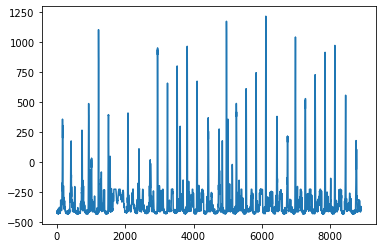

In [35]:
plt.plot(score_all)

Accuracy 	0.9322
AUC score 	0.5846
FAR score 	0.8742
Precision 	0.1258
Recall   	0.2151
Macro F1 	0.5617
Avg Precision 	0.0504
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8639
           1       0.13      0.22      0.16       265

    accuracy                           0.93      8904
   macro avg       0.55      0.58      0.56      8904
weighted avg       0.95      0.93      0.94      8904



[0.9321653189577718,
 0.5846278504456535,
 0.8741721854304636,
 0.12582781456953643,
 0.21509433962264152,
 0.561716033908637,
 0.050425138192225535]

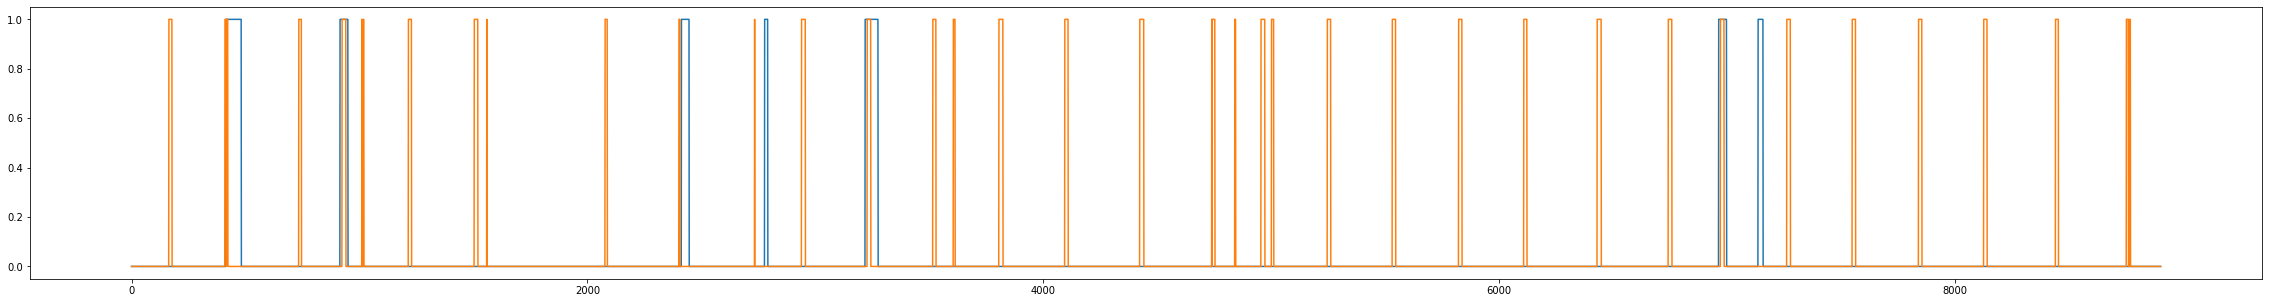

In [36]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

Accuracy 	0.9477
AUC score 	0.8450
FAR score 	0.6701
Precision 	0.3299
Recall   	0.7358
Macro F1 	0.7141
Avg Precision 	0.2507
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8639
           1       0.33      0.74      0.46       265

    accuracy                           0.95      8904
   macro avg       0.66      0.85      0.71      8904
weighted avg       0.97      0.95      0.96      8904



[0.9476639712488769,
 0.8450052089362194,
 0.6700507614213198,
 0.3299492385786802,
 0.7358490566037735,
 0.7140590474258268,
 0.25065447115538103]

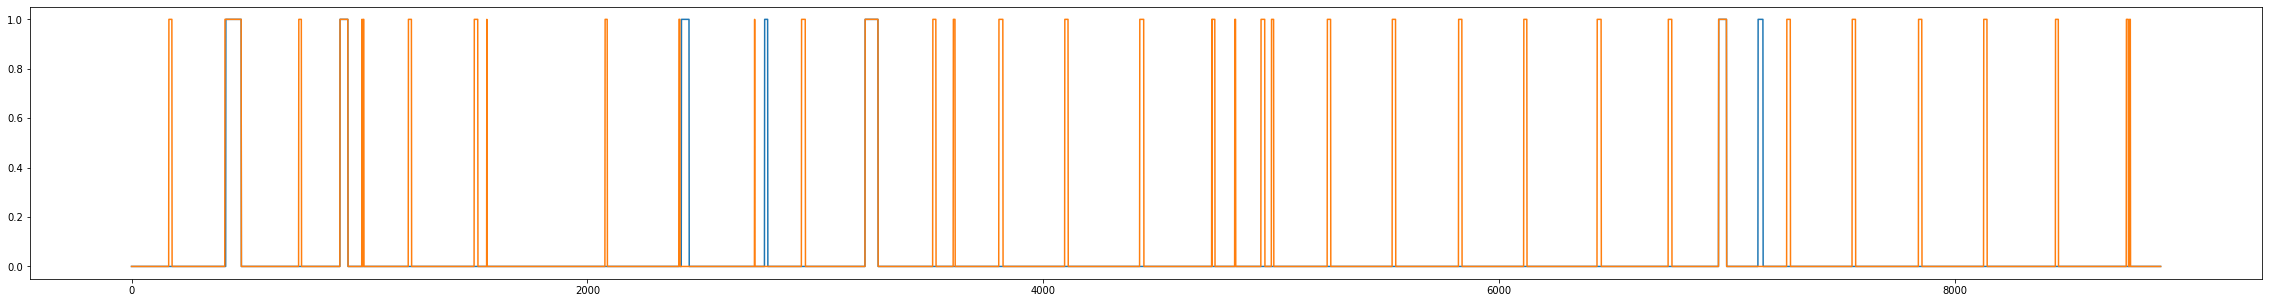

In [37]:
evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

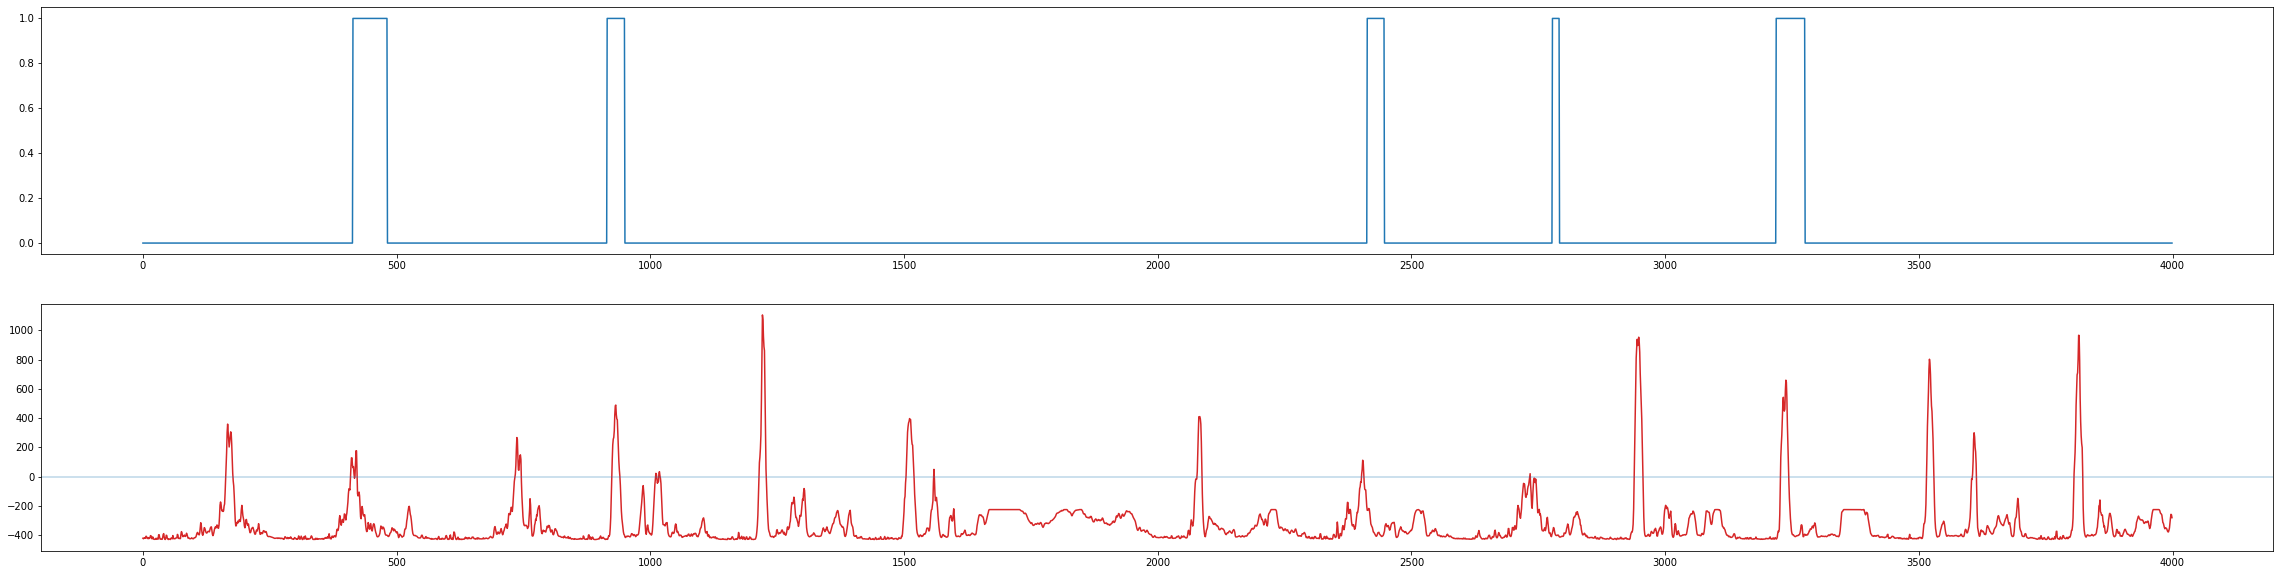

In [38]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


In [29]:
# def Cumulative(lists, window=12):
#     cu_list = []
#     length = len(lists)
#     cu_list = [(lists[x-window:x].mean()) for x in range(window, length)]
#     return cu_list + [0]*window

# # plt.plot(Cumulative(score_all, window=2))
# cum_score_all = Cumulative(score_all, window=)
# evaluate(label_all, cum_score_all, adjust=True, plot=False, print_=True)

## Case prediction plot

[1217.4974, 1175.4639, 1150.7797, 1117.448, 1116.9817, 1105.4968, 1098.2231, 1092.1052, 1075.908, 1074.1848, 1072.1907, 1044.1482, 1003.49133, 986.2919, 974.11804, 973.7555, 972.64, 966.7698, 964.80334, 957.6028, 953.4044, 945.04126, 939.04663, 926.4994, 920.562, 916.4607, 913.64417, 896.55005, 896.5325, 892.84753, 888.708, 882.84314, 878.0303, 861.333, 851.2207, 847.42017, 847.15137, 846.1843, 824.44165, 822.56506, 810.12415, 806.4785, 804.52783, 804.0725, 803.08057, 802.7645, 799.5303, 794.8773, 775.1853, 768.3799, 747.172, 735.0415, 730.4176, 717.66406, 709.7876, 704.2224, 703.281, 702.52344, 699.7097, 698.1979, 696.00366, 692.90894, 688.5825, 675.9431, 666.6488, 665.68054, 663.70825, 660.59204, 659.6749, 658.72876, 646.1625, 635.9938, 622.0647, 621.7732, 613.33765, 612.03284, 602.77563, 599.7759, 597.7134, 596.03455, 595.57153, 594.05347, 589.536, 585.8071, 580.76355, 578.02527, 574.48083, 573.93353, 569.98944, 567.99695, 566.9204, 562.8109, 558.98285, 550.4415, 549.7329, 542.8511,

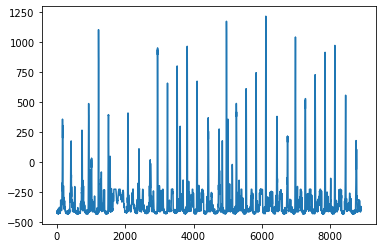

In [51]:
plt.plot(score_all)
print(sorted(score_all)[::-1])

In [69]:
detected = np.where(score_all > 0)[0]
# tmp = np.argsort(detected)[::-1]
tmp = np.random.choice(detected, 10)
tmp

array([3611, 6442, 2734, 3243, 2953,  422, 1218, 3528, 6756, 5543])

In [56]:
with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

# test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]
# test_df = test_df.rolling(window=3).mean()

In [57]:
test_df.index = pd.to_datetime(test_df.index)

In [58]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

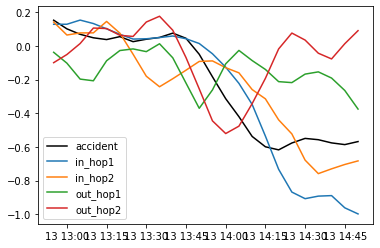

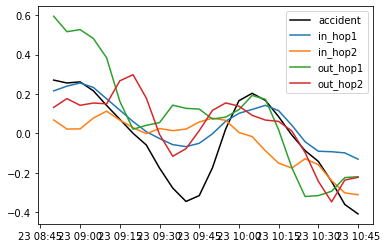

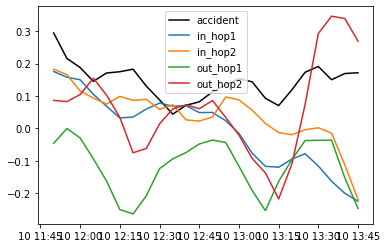

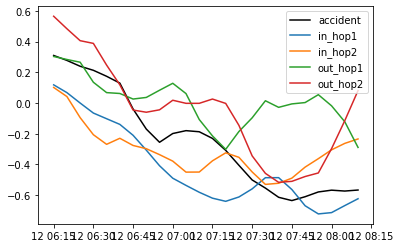

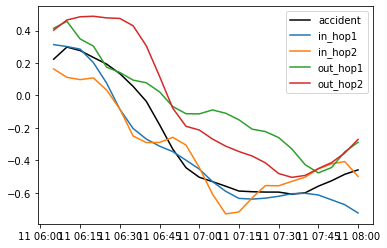

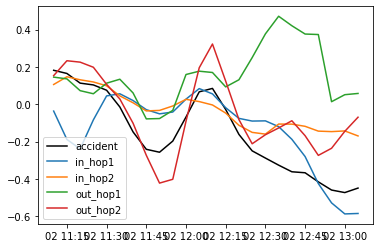

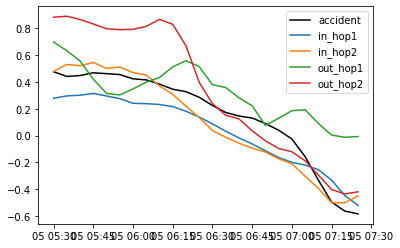

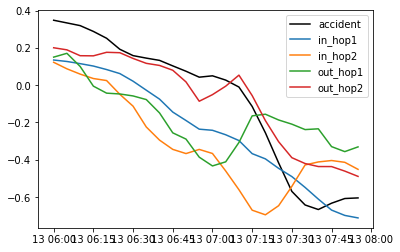

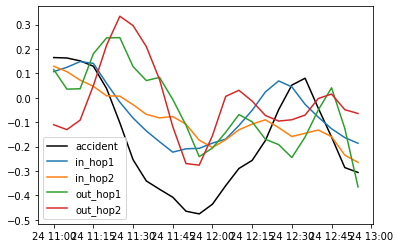

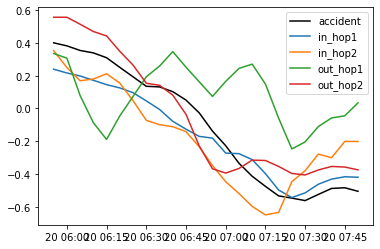

In [71]:
for i in tmp:
    plt.figure()
    plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
    plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
    plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
    plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
    plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
    plt.legend()
    plt.show()
    

### Prediction Case for true incident

Detected
MTTD =  [4]


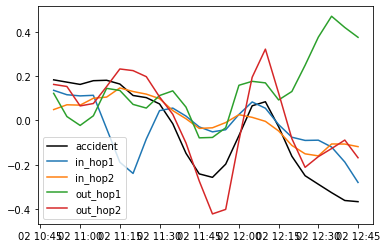

Detected
MTTD =  [9]


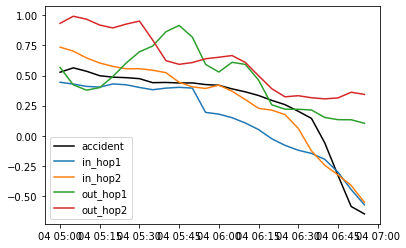

Not detected
Not detected
Detected
MTTD =  [9]


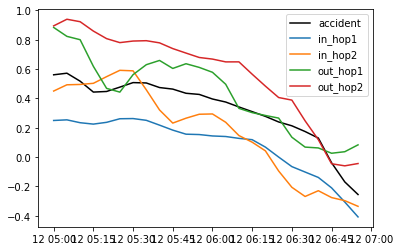

Detected
MTTD =  [8]


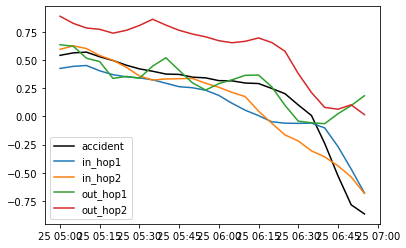

Not detected


In [72]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
    

In [73]:
accident_case

,eventId,created,startExpect,endExpect,start,end,cp,category,description,sids,lng,lat,accident_sid
45,3735057,2020-11-22 20:24:00,2020-11-22 20:21:00,2020-11-22 20:41:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차끼리 추돌사고로 정체,[1210005301],127.006911,37.515645,1210005301
136,3736508,2020-11-24 07:20:00,2020-11-24 07:19:00,2020-11-24 07:39:00,NaN,NaN,tbs 교통방송,ACCIDENT,"올림픽대로 공항방면 (한남대교 → 반포대교) 3,4차로 승용차,화물차 추돌사고 처리...",[1210005301],127.006436,37.515302,1210005301
147,3736513,2020-11-24 07:26:19,2020-11-24 07:20:00,2020-11-24 07:50:00,NaN,NaN,경찰청(UTIC),ACCIDENT,"[사고] 올림픽대로 한남대교 에서 반포대교 방향 3,4차로 교통사고 주의운전",[1210005301],127.007420,37.516077,1210005301
20,3741845,2020-11-29 11:47:24,2020-11-29 11:45:00,2020-11-29 12:15:00,NaN,NaN,경찰청(UTIC),ACCIDENT,[사고] 올림픽대로 한남대교 에서 반포대교 방향 2차로 교통사고,[1210005301],127.011501,37.519593,1210005301
91,3748667,2020-12-06 19:31:00,2020-12-06 19:29:00,2020-12-06 19:49:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.005848,37.514726,1210005301
104,3751949,2020-12-10 06:57:00,2020-12-10 06:55:00,2020-12-10 07:15:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.005418,37.514365,1210005301
91,3756142,2020-12-15 07:10:00,2020-12-15 07:07:00,2020-12-15 07:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 (하남 → 공항) 반포대교 조금 못 간 지점 2차로 승용차관련 추돌사고 ...,[1210005301],127.003518,37.512955,1210005301
175,3760761,2020-12-21 06:55:00,2020-12-21 06:53:00,2020-12-21 07:13:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 1차로 추돌사고로 정체,[1210005301],127.006934,37.515717,1210005301
25,3762631,2020-12-23 07:54:00,2020-12-23 07:50:00,2020-12-23 08:10:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 3차로 승용차관련 추돌사고 처리작업으로 정체,[1210005301],127.006594,37.515446,1210005301
139,3769104,2021-01-02 14:10:00,2021-01-02 14:07:00,2021-01-02 14:27:00,NaN,NaN,tbs 교통방송,ACCIDENT,올림픽대로 공항방면 (한남대교 → 반포대교) 2차로 추돌사고 처리작업으로 정체,[1210005301],127.006685,37.515446,1210005301


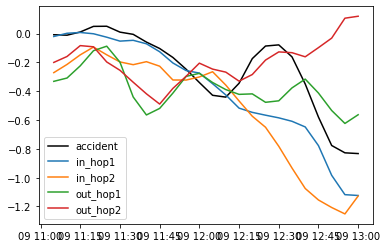

2437 0


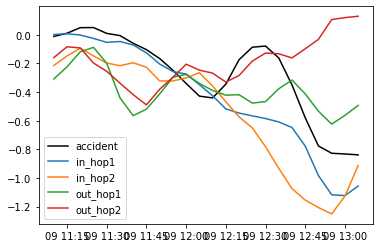

2438 0


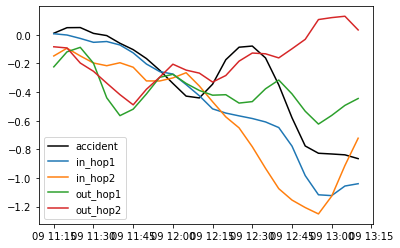

2439 0


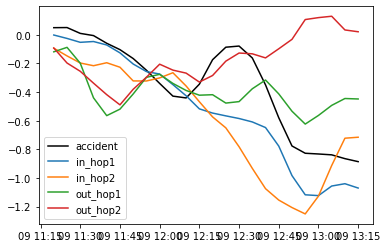

2440 0


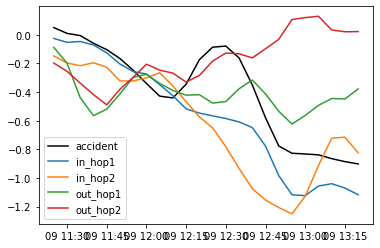

2441 0


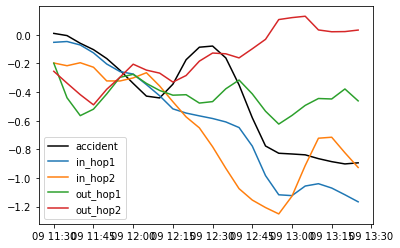

2442 0


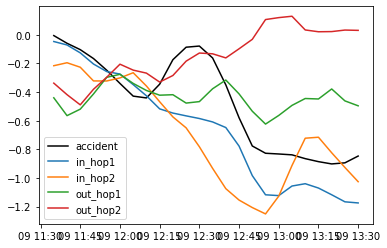

2443 0


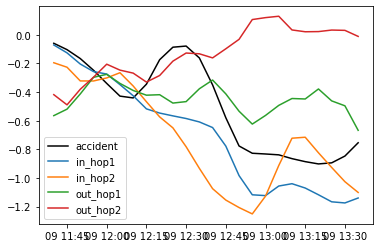

2444 0


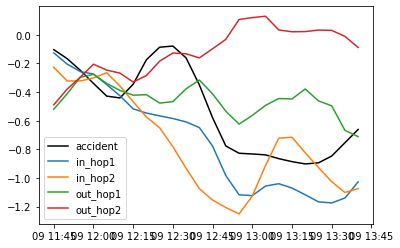

2445 0


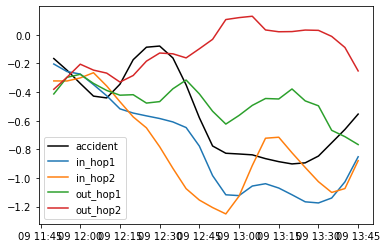

2446 0


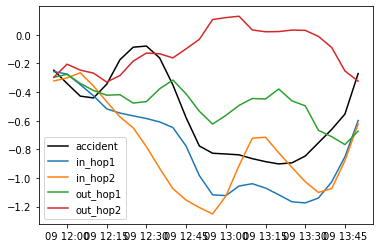

2447 0


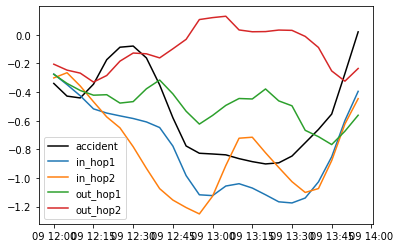

2448 0


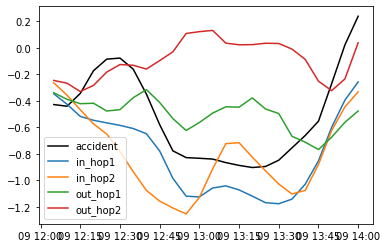

2449 0


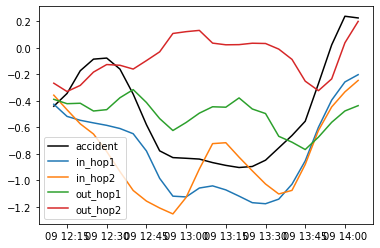

2450 0


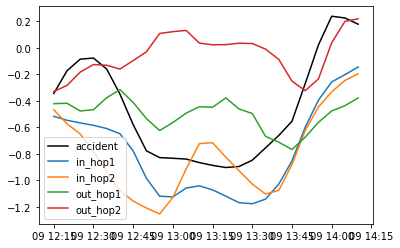

2451 0


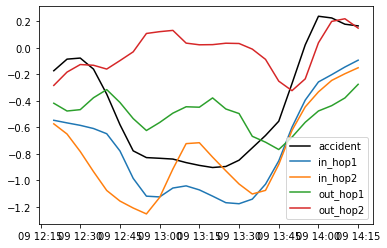

2452 0


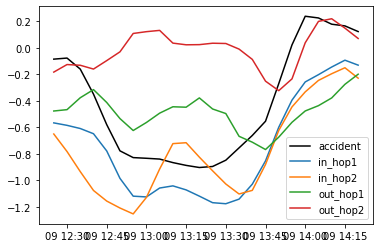

2453 0


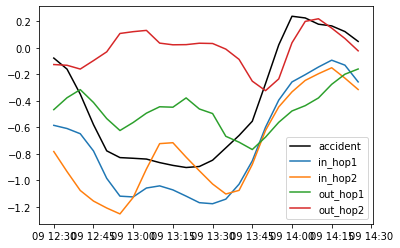

2454 0


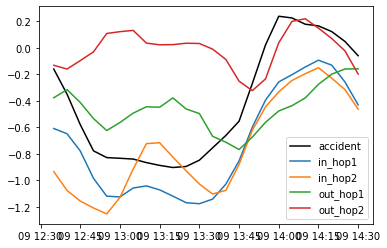

2455 0


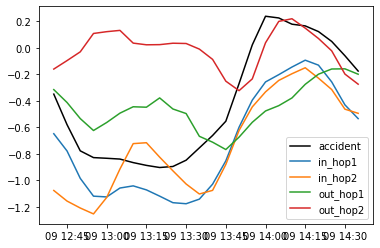

2456 0


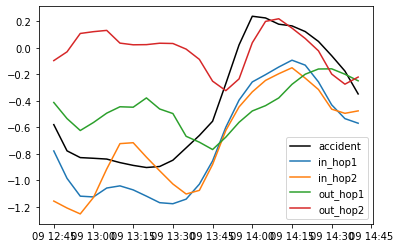

2457 0


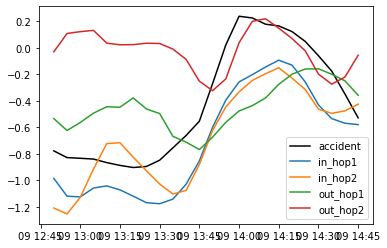

2458 0


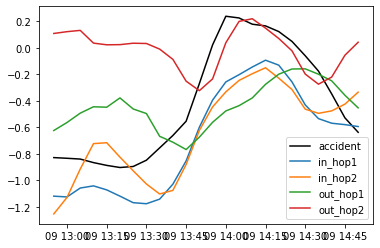

2459 0


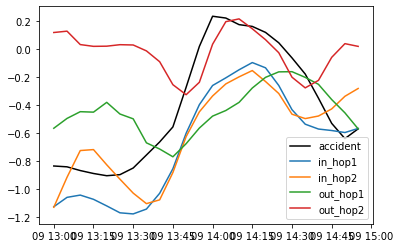

2460 0


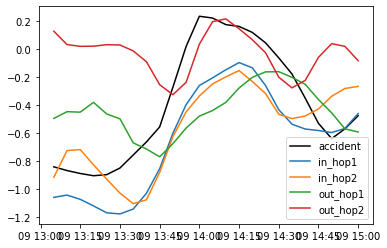

2461 0


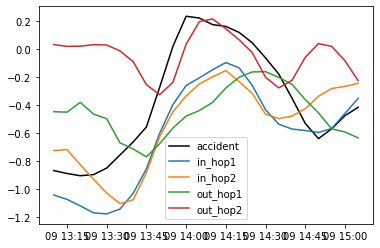

2462 0


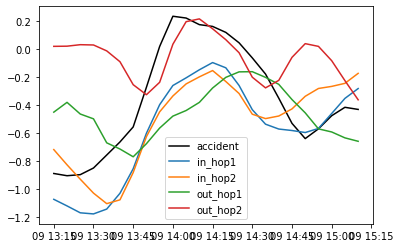

2463 0


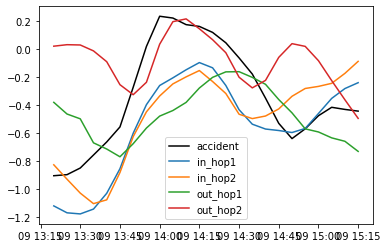

2464 0


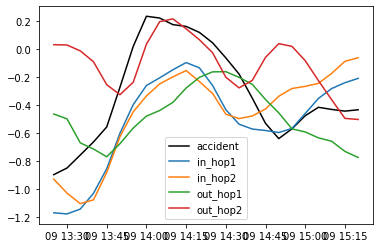

2465 0


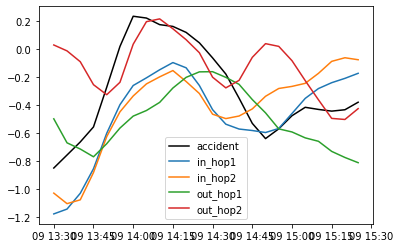

2466 0


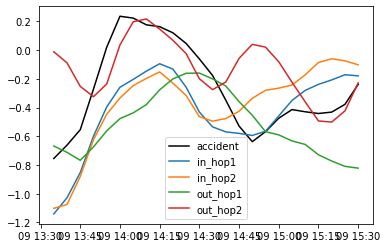

2467 0


In [76]:
cnt = 0
for i in range(1100, len(train_df)):
    
    if test_label.iloc[i, 0] == 0:
        continue
    else:
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
        print(i, pred[i])
        cnt += 1
    if cnt > 30 :
        break
    

### embedding distribution plot

#### Test set

/tmp/ipykernel_1743495/241259679.py:18: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


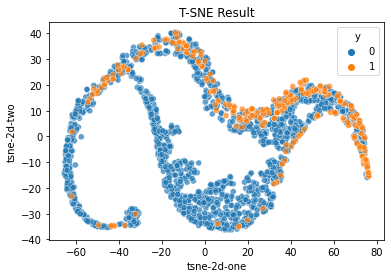

/tmp/ipykernel_1743495/241259679.py:40: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


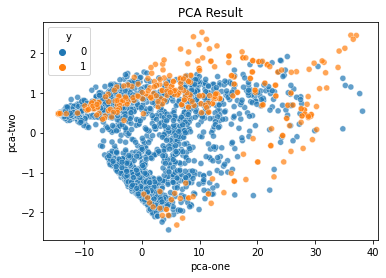

In [118]:
import seaborn as sns 

rndperm = np.random.permutation(2000)


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_all = tsne.fit_transform(np.concatenate(out_all))

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = label_all

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(np.concatenate(out_all))

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = label_all

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)

plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

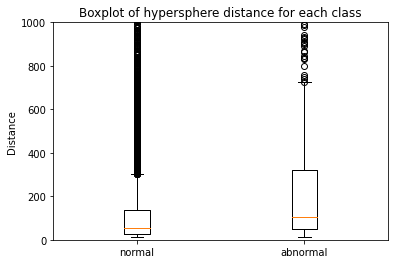

In [127]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

#### Train set

In [90]:
out_train, dist_train, score_train = [], [], []
label_train = []
for ix, data in tqdm(enumerate(train_loader)):
    output = model(data.cuda())
    out_train.append(output.cpu().detach().numpy())
    label_train.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_train.append(dist.cpu().detach().numpy())
    score_train.append(score.cpu().detach().numpy())
label_train = np.concatenate(label_train)
score_train = np.concatenate(score_train)
dist_train = np.concatenate(dist_train)

405it [00:02, 176.61it/s]


In [107]:
random_out_train = np.concatenate(out_train)[np.append(rndperm, abnormal)]
np.concatenate(out_train).shape

(25894, 32)

/tmp/ipykernel_1743495/1031594659.py:21: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


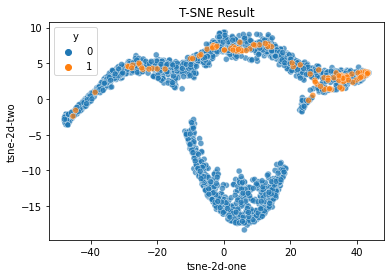

In [116]:
import seaborn as sns 

# rndperm1 = np.random.permutation(10000)
rndperm = np.random.permutation(2000)


normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]

random_out_train = np.concatenate(out_train)[np.append(rndperm, abnormal)]

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_all = tsne.fit_transform(random_out_train)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = label_train[np.append(rndperm, abnormal)]

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df,
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


/tmp/ipykernel_1743495/2460715216.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


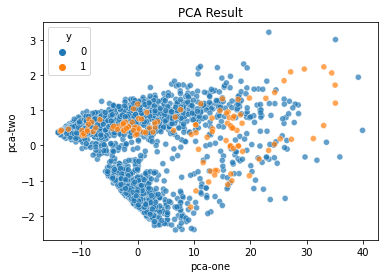

In [117]:
## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(random_out_train)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = label_train[np.append(rndperm, abnormal)]

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df,
    legend="full",
    alpha=0.7
)

plt.title('PCA Result')
plt.show()

In [121]:
abnormal

array([  423,   472,   895,  1225,  1435,  1756,  2127,  2471,  2526,
        2757,  2769,  2805,  2810,  2917,  3126,  3176,  3332,  3838,
        3978,  4125,  4238,  4525,  4637,  5076,  5243,  5331,  5371,
        5418,  5497,  5573,  6123,  6410,  7223,  7328,  8406,  9279,
        9398,  9857, 10069, 10132, 10210, 10610, 11228, 11712, 12405,
       12440, 12574, 12908, 12927, 12991, 13052, 13168, 13209, 13210,
       13536, 13911, 13926, 14255, 14523, 14963, 15202, 15369, 15532,
       15690, 16155, 16491, 16774, 17074, 17098, 17609, 17664, 17967,
       18111, 18122, 18186, 18290, 18312, 18780, 18972, 19171, 19195,
       19459, 19861, 20041, 20173, 20371, 20464, 20549, 21000, 21583,
       22051, 22264, 22427, 22619, 22805, 22846, 22884, 23657, 23865,
       23936, 24016, 24050, 24296, 24531, 24878, 24937, 25165, 25570,
       25828])

Text(0, 0.5, 'Distance')

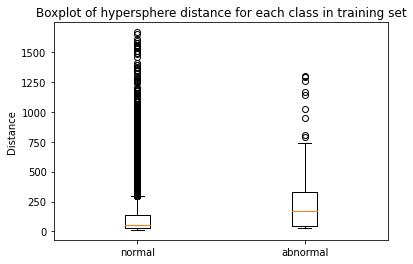

In [124]:
normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]

plt.boxplot([dist_train[normal], dist_train[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

#### Train set Recur vs Non-recur

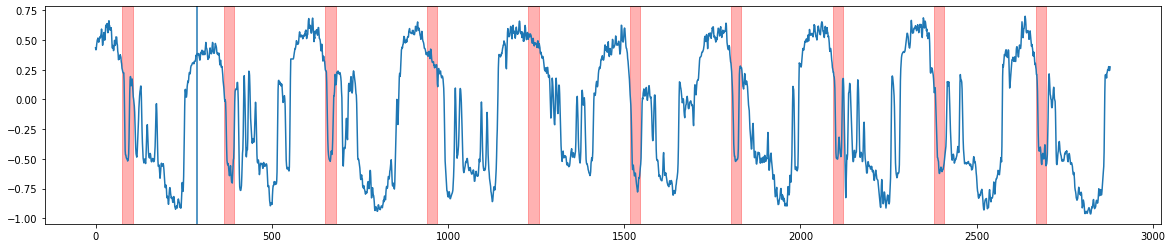

In [193]:
plt.figure(figsize=(20, 4))
plt.plot(train_df.iloc[:288*10][target_sid].values)
plt.axvline(288)
t0 = 76
t1 = 105
for i in range(10):
    plt.axvspan(t0+288*i, t1+288*i, color='r', alpha=0.3)


In [229]:
recurrent_label = np.zeros(train_label.shape)
t0 = 76
t1 = 105
for i in range(len(train_label) // 288):
    date = train_df.index[t0+288*i]
    if datetime.strptime(date, '%Y-%m-%d %H:%M:%S').weekday() <= 4:
        recurrent_label[t0+288*i:t1+288*i] = 1

In [205]:
(recurrent_label==1).sum()

1827

In [210]:

for ix, data in enumerate(train_loader):
    if recurrent_label[ix] == 1:
        for b in range(64):
            ixs = np.where(data.batch == b)[0]
            for i in range(5):
                plt.plot(data.x[ixs][i])
            break
    break

/tmp/ipykernel_1743495/2921437937.py:29: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


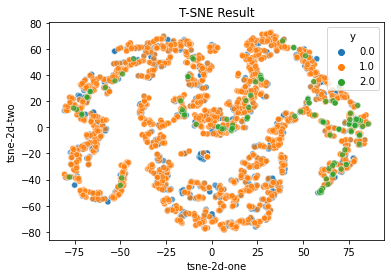

In [263]:
import seaborn as sns 



# normal = np.where(label_train == 0)[0]
# rndperm = np.random.choice(normal, 2000)

recurrent = np.where(recurrent_label == 1)[0]
nonrecurrent = np.where(label_train == 1)[0]

new_label = np.zeros(len(label_train))
new_label[recurrent] = 1
new_label[nonrecurrent] = 2

rndperm = np.random.choice(np.where(new_label==0)[0], 1000)

random_out_train = np.concatenate(out_train)[np.concatenate([rndperm, recurrent, nonrecurrent])]


## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10)
tsne_all = tsne.fit_transform(random_out_train)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = new_label[np.concatenate([rndperm, recurrent, nonrecurrent])]

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df,
    legend="full",
    alpha=0.7
)

plt.title('T-SNE Result')
plt.show()


Text(0, 0.5, 'Distance')

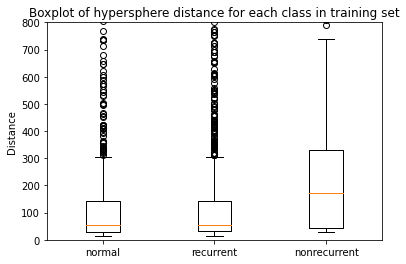

In [262]:
plt.boxplot([dist_train[rndperm], dist_train[recurrent], dist_train[nonrecurrent]])
plt.ylim(0, 800)
plt.xticks([1, 2, 3],['normal', 'recurrent', 'nonrecurrent'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

## 1902 + 5301

In [36]:
out_sumpool_5301 = pd.read_csv('result/OCGNN_sumpool_acc5301.csv', index_col=0)
out_sumpool_1902 = pd.read_csv('result/OCGNN_sumpool_acc1902.csv', index_col=0)

In [37]:
out_sumpool_5301['pooling'] = 'sum'
out_sumpool_1902['pooling'] = 'sum'

In [41]:
out_sumpool = out_sumpool_5301.copy()
out_sumpool.iloc[:, 4:-1] = (out_sumpool_5301.iloc[:, 4:-1] + out_sumpool_1902.iloc[:, 4:-1])/2
out_sumpool

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP,pooling
0,GCN_gc,standard,0.05,False,0.937037,0.498027,0.987178,0.012822,0.046822,0.493745,0.013495,sum
1,GCN_gc,standard,0.05,True,0.943852,0.749310,0.867412,0.132588,0.549389,0.591962,0.078745,sum
2,GCN_traffic,standard,0.05,False,0.949896,0.490901,0.993196,0.006804,0.019129,0.492162,0.013424,sum
3,GCN_traffic,standard,0.05,True,0.952946,0.612892,0.919920,0.080080,0.263111,0.549208,0.042544,sum
4,GraphSAGE_gc,standard,0.05,False,0.953603,0.491720,0.992717,0.007283,0.017001,0.493152,0.013426,sum
5,GraphSAGE_gc,standard,0.05,True,0.956615,0.602502,0.906423,0.093577,0.238565,0.555500,0.032447,sum
6,GCN_gc,standard,0.10,False,0.845304,0.479142,0.990473,0.009527,0.102704,0.466461,0.013146,sum
7,GCN_gc,standard,0.10,True,0.853723,0.787214,0.930209,0.069791,0.718849,0.523047,0.054706,sum
8,GCN_traffic,standard,0.10,False,0.903808,0.491957,0.989213,0.010787,0.068628,0.484028,0.013399,sum
9,GCN_traffic,standard,0.10,True,0.912728,0.826038,0.894636,0.105364,0.736790,0.569068,0.082211,sum
